<a href="https://colab.research.google.com/github/nikhilreddybilla28/Ads-and-Sales-Data-Analysis/blob/master/Adversarial_Example_(Attack_and_defense).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [28]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=256,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

In [14]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 196 Validation data: 313 Test data:  10000


In [15]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

##Attack

In [16]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [17]:
model = Net().to(device)

In [18]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [19]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [20]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 1.0135123054591977 Val_Loss: 0.4868142439629704
Epoch: 2 Loss: 0.4112967827490398 Val_Loss: 0.3705243227866511
Epoch: 3 Loss: 0.3217819430390183 Val_Loss: 0.30493145212293055
Epoch: 4 Loss: 0.2697945060778637 Val_Loss: 0.25903273963580686
Epoch: 5 Loss: 0.2300073910428553 Val_Loss: 0.21988610133005027
Epoch: 6 Loss: 0.20297797324554046 Val_Loss: 0.20117360978913953
Epoch: 7 Loss: 0.17902849538593876 Val_Loss: 0.17655899855918206
Epoch: 8 Loss: 0.1618222821579904 Val_Loss: 0.15675941395897644
Epoch: 9 Loss: 0.14154393035842447 Val_Loss: 0.1494028178124001
Epoch: 10 Loss: 0.12919271598589055 Val_Loss: 0.13194703791861812


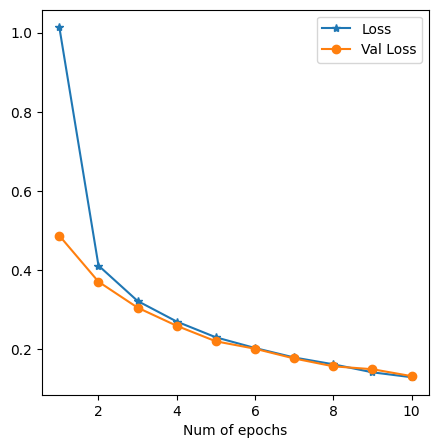

In [21]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [22]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [23]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
          continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)

      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples


In [32]:
epsilons = [0, 0.01,  0.04, 0.16, 0.32, 0.64]
attack_types = ["fgsm","ifgsm","mifgsm"]
accuracy_data = {
    "fgsm": [],
    "ifgsm": [],
    "mifgsm": []}
for attack in ["fgsm","ifgsm","mifgsm"]:
  print(f"attack:{attack}")
  for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracy_data[attack].append(acc)
      #examples[attack].append(ex)


print(accuracy_data)
#print(examples)



  # plt.figure(figsize=(5,5))
  # plt.plot(epsilons, accuracies, "*-")
  # plt.title(attack)
  # plt.xlabel("Epsilon")
  # plt.ylabel("Accuracy")
  # plt.show()

  # cnt = 0
  # plt.figure(figsize=(8,10))
  # for i in range(len(epsilons)):
  #     for j in range(len(examples[i])):
  #         cnt += 1
  #         plt.subplot(len(epsilons),len(examples[0]),cnt)
  #         plt.xticks([], [])
  #         plt.yticks([], [])
  #         if j == 0:
  #             plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
  #         orig,adv,ex = examples[i][j]
  #         plt.title("{} -> {}".format(orig, adv))
  #         plt.imshow(ex, cmap="gray")
  # plt.tight_layout()
  # plt.show()

attack:fgsm
Epsilon: 0	Test Accuracy = 9469 / 10000 = 0.9469
Epsilon: 0.01	Test Accuracy = 9413 / 10000 = 0.9413
Epsilon: 0.04	Test Accuracy = 9217 / 10000 = 0.9217
Epsilon: 0.16	Test Accuracy = 4994 / 10000 = 0.4994
Epsilon: 0.32	Test Accuracy = 393 / 10000 = 0.0393
Epsilon: 0.64	Test Accuracy = 17 / 10000 = 0.0017
attack:ifgsm
Epsilon: 0	Test Accuracy = 9464 / 10000 = 0.9464
Epsilon: 0.01	Test Accuracy = 9423 / 10000 = 0.9423
Epsilon: 0.04	Test Accuracy = 9256 / 10000 = 0.9256
Epsilon: 0.16	Test Accuracy = 5931 / 10000 = 0.5931
Epsilon: 0.32	Test Accuracy = 673 / 10000 = 0.0673
Epsilon: 0.64	Test Accuracy = 16 / 10000 = 0.0016
attack:mifgsm
Epsilon: 0	Test Accuracy = 9471 / 10000 = 0.9471
Epsilon: 0.01	Test Accuracy = 9412 / 10000 = 0.9412
Epsilon: 0.04	Test Accuracy = 9259 / 10000 = 0.9259
Epsilon: 0.16	Test Accuracy = 5968 / 10000 = 0.5968
Epsilon: 0.32	Test Accuracy = 671 / 10000 = 0.0671
Epsilon: 0.64	Test Accuracy = 15 / 10000 = 0.0015
{'fgsm': [0.9469, 0.9413, 0.9217, 0.4994, 0

In [33]:
print(accuracy_data)

{'fgsm': [0.9469, 0.9413, 0.9217, 0.4994, 0.0393, 0.0017], 'ifgsm': [0.9464, 0.9423, 0.9256, 0.5931, 0.0673, 0.0016], 'mifgsm': [0.9471, 0.9412, 0.9259, 0.5968, 0.0671, 0.0015]}


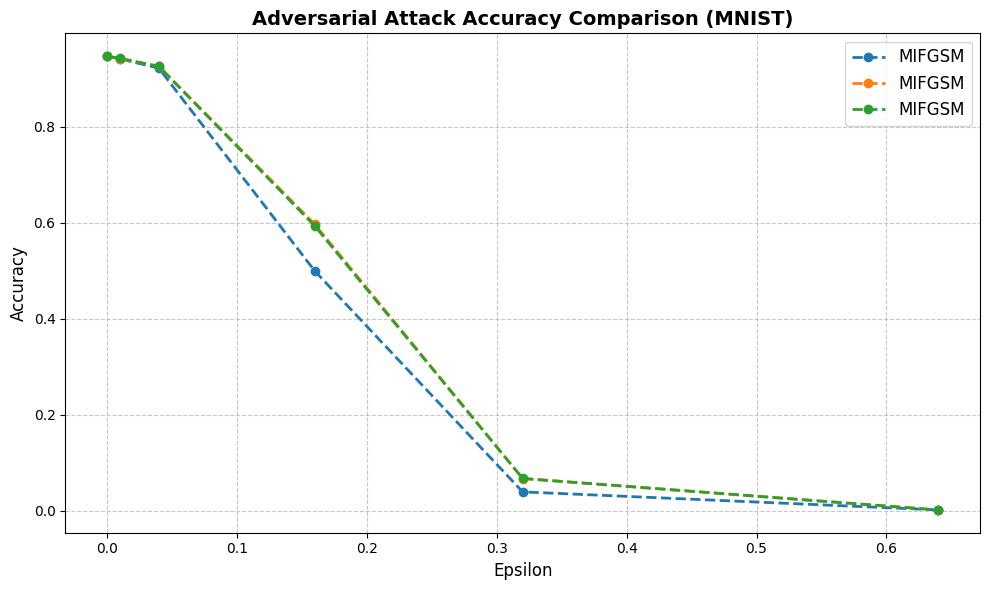

In [41]:
# Plot accuracy curves for all attacks
accuracy_data = {'fgsm': [0.9469, 0.9413, 0.9217, 0.4994, 0.0393, 0.0017],
                   'ifgsm': [0.9464, 0.9423, 0.9256, 0.5931, 0.0673, 0.0016],
                   'mifgsm': [0.9471, 0.9412, 0.9259, 0.5968, 0.0671, 0.0015]}
plt.figure(figsize=(10, 6))
attack_types = ["fgsm","ifgsm","mifgsm"]
plt.plot(epsilons, accuracy_data["fgsm"], label="FGSM",  linestyle='--', marker='o', linewidth=2)
plt.plot(epsilons, accuracy_data['ifgsm'], label='IFGSM',  linestyle='--', marker='o', linewidth=2)
plt.plot(epsilons, accuracy_data["mifgsm"], label="MIFGSM",  linestyle='--', marker='o', linewidth=2)
plt.title("Adversarial Attack Accuracy Comparison (MNIST)", fontsize=14, weight='bold')
plt.xlabel("Epsilon", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

##Defense

In [42]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [43]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  alpha = epsilon/iter
  pert_out = input
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [44]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)

    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc,adv_examples

In [52]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  accuracy_data = {
    "fgsm": [],
    "ifgsm": [],
    "mifgsm": []}
  for attack in ["fgsm","ifgsm","mifgsm"]:
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex = test(model,device,test_loader,eps,Temp,attack)
        accuracies.append(acc)
        accuracy_data[attack].append(acc)
        #examples.append(ex)
    print(f"{attack}:{accuracies}")
    # plt.figure(figsize=(5,5))
    # plt.plot(epsilons, accuracies, "*-")
    # plt.title(attack)
    # plt.xlabel("Epsilon")
    # plt.ylabel("Accuracy")
    # plt.show()
    print(accuracy_data)
  return accuracy_data

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 2.1026889256068637 Val_Loss: 1.5533008826807284
Epoch: 2 Loss: 1.0250406538953587 Val_Loss: 0.7400442286611746
Epoch: 3 Loss: 0.6324905245279779 Val_Loss: 0.5659602520564875
Epoch: 4 Loss: 0.5143434498078969 Val_Loss: 0.48359129818293234
Epoch: 5 Loss: 0.44983999841675465 Val_Loss: 0.43552163362312624
Epoch: 6 Loss: 0.41386574278680643 Val_Loss: 0.404108863002576
Epoch: 7 Loss: 0.3835504839614946 Val_Loss: 0.3778370753073464
Epoch: 8 Loss: 0.3638508379155276 Val_Loss: 0.35999554133834166
Epoch: 9 Loss: 0.343045709692702 Val_Loss: 0.34459802498832676
Epoch: 10 Loss: 0.32786852927232274 Val_Loss: 0.337913946816906


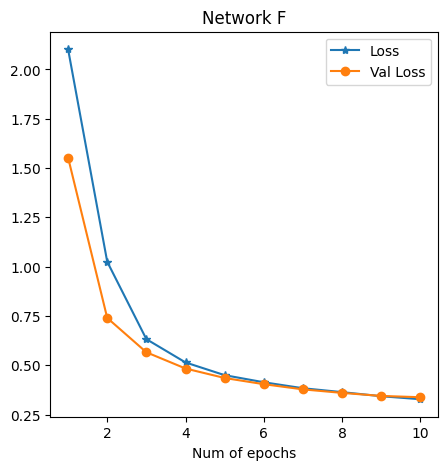

Fitting the model...
Epoch: 1 Loss: 2.2852618524006436 Val_Loss: 2.2292676154797832
Epoch: 2 Loss: 1.9400073016176418 Val_Loss: 1.5294032199695087
Epoch: 3 Loss: 1.176821525303685 Val_Loss: 0.933941727629104
Epoch: 4 Loss: 0.8232157583139381 Val_Loss: 0.7454935160879129
Epoch: 5 Loss: 0.6837834533380003 Val_Loss: 0.6482549041223983
Epoch: 6 Loss: 0.6057324518962782 Val_Loss: 0.5918683554893865
Epoch: 7 Loss: 0.5608332623936692 Val_Loss: 0.5560619348820787
Epoch: 8 Loss: 0.5245761033527705 Val_Loss: 0.5247010027352994
Epoch: 9 Loss: 0.4976858388708562 Val_Loss: 0.5022760949576625
Epoch: 10 Loss: 0.47754676533596857 Val_Loss: 0.4763905662602891


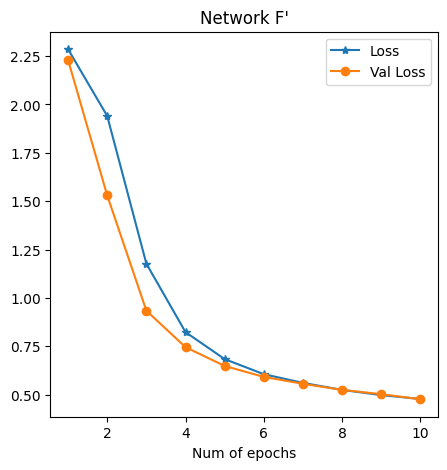

TypeError: test() missing 1 required positional argument: 'attack'

In [53]:
Temp=100
epochs=10
epsilons=[0, 0.01,  0.04, 0.16, 0.32, 0.64]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)

In [ ]:
epsilon = [0, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64]

acc_without_def = {'fgsm': [0.9469, 0.9413, 0.9217, 0.4994, 0.0393, 0.0017],
                   'ifgsm': [0.9464, 0.9423, 0.9256, 0.5931, 0.0673, 0.0016],
                   'mifgsm': [0.9471, 0.9412, 0.9259, 0.5968, 0.0671, 0.0015]}

acc_with_def = np.array([0.9268, 0.366, 0.151, 0.08, 0.072, 0.081, 0.076, 0.084, 0.09])
for attack in ['fgsm', 'ifgsm', 'mifgsm']:
  accuracy_no_defense= np.array(acc_without_def[attack])
  accuracy_with_defense = np.array(acc_with_def)
  # Create an improved graph
  plt.figure(figsize=(10, 6))
  plt.plot(epsilon, accuracy_no_defense, label=" without defense", marker='o', linestyle='--', linewidth=2, color='red')
  plt.plot(epsilon, accuracy_with_defense, label=" with defensive-distillation", marker='s', linestyle='-', linewidth=2, color='blue')

  # Enhance the graph with labels, grid, and title
  plt.title("FGSM Attack on CIFAR 10 Accuracy Plot", fontsize=14, weight='bold')
  plt.xlabel("Epsilon (Attack Strength)", fontsize=12)
  plt.ylabel("Accuracy", fontsize=12)
  plt.grid(visible=True, linestyle='--', alpha=0.7)

  # Change legend position
  plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize=12) # Adjusted bbox_to_anchor

  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.tight_layout()

  # Save and display the improved graph
  improved_graph_path = f"graph{attack}.png"
  plt.savefig(improved_graph_path)
  plt.show()

